In [66]:
import gc
import gzip
import json
from typing import Iterator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score

In [27]:
# Đọc dữ liệu từ file ratings.csv
r_cols = ['user', 'item', 'rating', 'unix_timestamp']
train_data = pd.read_csv('/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
test_data = pd.read_csv('/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')

In [28]:
train_data["user"] = train_data.groupby("user").ngroup()
train_data["item"] = train_data.groupby("item").ngroup()

n_users = len(train_data["user"].unique())

user_vector = np.asarray(train_data["user"].astype(np.int32))

n_items = len(train_data["item"].unique())

item_vector = np.asarray(train_data["item"].astype(np.int32))

X_train = np.array([user_vector, item_vector]).T
y_train = train_data["rating"].values

In [29]:
test_data["user"] = test_data.groupby("user").ngroup()
test_data["item"] = test_data.groupby("item").ngroup()

n_users = len(test_data["user"].unique())

user_vector = np.asarray(test_data["user"].astype(np.int32))

n_items = len(test_data["item"].unique())

item_vector = np.asarray(test_data["item"].astype(np.int32))

X_test = np.array([user_vector, item_vector]).T
y_test = test_data["rating"].values

In [30]:
latent_factors = 80

In [31]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [49]:
def dmf_neural_network(
    n_users: int,
    n_item: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    users_input = tf.keras.layers.Input(shape=[1], dtype="int32", name="users_input")
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(users_input)
    u = tf.keras.layers.Flatten()(u)

    items_input = tf.keras.layers.Input(shape=[1], dtype="int32", name="items_input")
    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(items_input)
    i = tf.keras.layers.Flatten()(i)

    x = tf.keras.layers.Concatenate(name="concatenated_vector")([i, u])

    for n in [1, 2, 4]:

        x = tf.keras.layers.Dense(
            units=200 / n,
            activation="elu",
            kernel_initializer="glorot_normal",
        )(x)
        x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(
        units=12, activation="elu", kernel_initializer="glorot_normal"
    )(x)

    output = tf.keras.layers.Dense(units=1)(x)

    return tf.keras.Model(inputs=[users_input, items_input], outputs=output)

In [50]:
model = dmf_neural_network(
    n_users=n_users,
    n_item=n_items,
    n_latent_factors=latent_factors,
)

model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 items_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 users_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 items_embedding (Embedding  (None, 1, 80)                90400     ['items_input[0][0]']         
 )                                                                                                
                                                                                                  
 users_embedding (Embedding  (None, 1, 80)                75520     ['users_input[0][0]']   

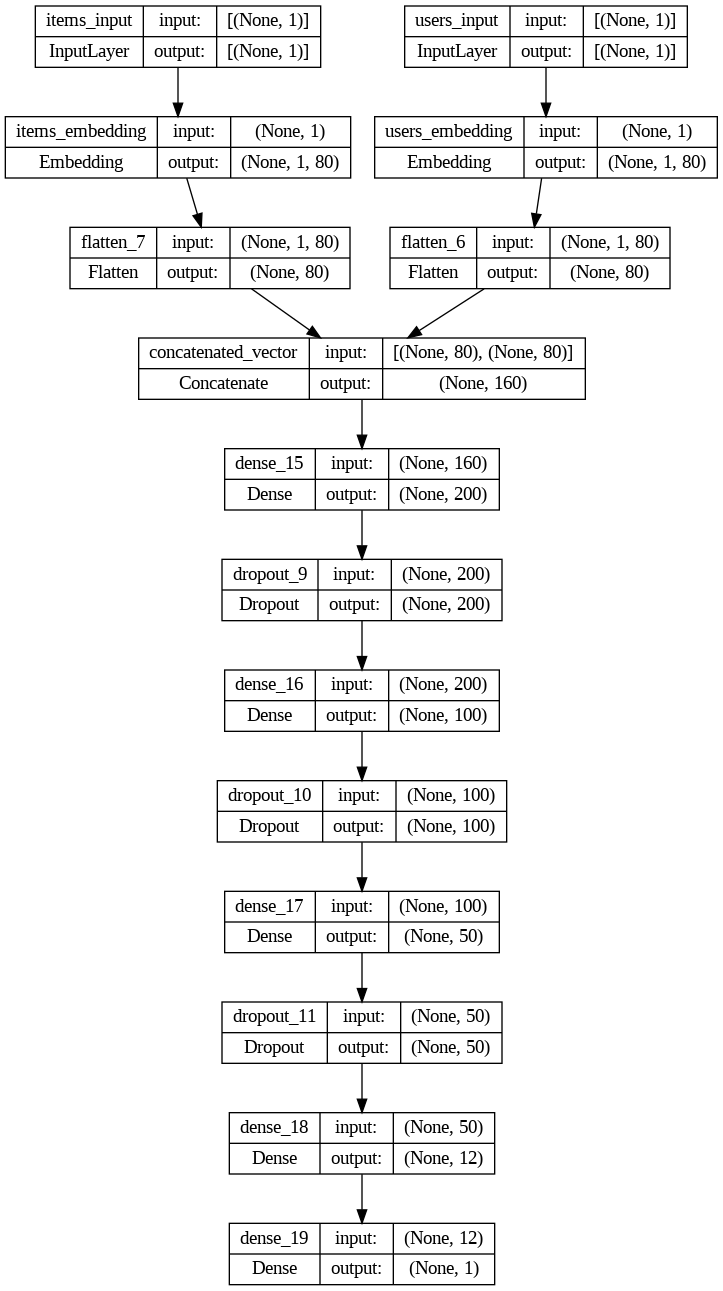

In [51]:
tf.keras.utils.plot_model(
    model, to_file="DMF_model.png", show_shapes=True, show_layer_names=True
)

In [52]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=40, restore_best_weights=True
)

In [53]:
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    epochs=100,
    validation_split=0.1,
    batch_size=256,
    callbacks=[callback],
)

Epoch 1/100
319/319 [==============================] - 11s 28ms/step - loss: 1.4342 - root_mean_squared_error: 1.1976 - val_loss: 1.0565 - val_root_mean_squared_error: 1.0279
Epoch 2/100
319/319 [==============================] - 2s 6ms/step - loss: 0.9296 - root_mean_squared_error: 0.9641 - val_loss: 1.0464 - val_root_mean_squared_error: 1.0229
Epoch 3/100
319/319 [==============================] - 2s 6ms/step - loss: 0.9017 - root_mean_squared_error: 0.9496 - val_loss: 1.0371 - val_root_mean_squared_error: 1.0184
Epoch 4/100
319/319 [==============================] - 2s 6ms/step - loss: 0.8857 - root_mean_squared_error: 0.9411 - val_loss: 1.0256 - val_root_mean_squared_error: 1.0127
Epoch 5/100
319/319 [==============================] - 2s 6ms/step - loss: 0.8740 - root_mean_squared_error: 0.9349 - val_loss: 1.0273 - val_root_mean_squared_error: 1.0136
Epoch 6/100
319/319 [==============================] - 2s 5ms/step - loss: 0.8627 - root_mean_squared_error: 0.9288 - val_loss: 1.037

In [55]:
evaluation = model.evaluate(x=[X_test[:, 0], X_test[:, 1]], y=y_test, verbose=1)

295/295 [==============================] - 1s 2ms/step - loss: 1.3403 - root_mean_squared_error: 1.1577


In [56]:
mse, rmse = evaluation

print("test MSE  = " + str(mse))
print("test RMSE = " + str(rmse))

test MSE  = 1.3403152227401733
test RMSE = 1.1577198505401611


In [57]:
predictions_test = model.predict([X_test[:, 0], X_test[:, 1]])

295/295 [==============================] - 1s 3ms/step


In [67]:
binary_labels = (true_rankings_test >= 4).astype(int)
binary_predictions = (predictions_test >= 4).astype(int)
precision = precision_score(binary_labels, binary_predictions)
recall = recall_score(binary_labels, binary_predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 0.7278
Recall: 0.2684
